In [2]:

import torch
from torch import optim
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve

import numpy as np
import matplotlib.pyplot as plt
import yaml

from aptamer_transformer.factories_model_loss import get_model
from aptamer_transformer.data_utils import load_dataset, read_cfg
from aptamer_transformer.metric_utils import *
from aptamer_transformer.training_utils import *


%load_ext autoreload
%autoreload 2

2024-03-11 21:12:51.125642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 21:12:52.035420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
cfg['device'] = 'cpu'
model = get_model(cfg)

total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

58962562

# Seq Struct X Aptmer Bert Analysis

### Masked Language Modeling

In [7]:
cfg = read_cfg('../aptamer_transformer/config.yaml')


tokenizer = AutoTokenizer.from_pretrained(cfg['seq_struct_tokenizer_path'])

y_true_list, y_pred_list = load_test_predictions(
    filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)

y_pred_flat_src = []
y_pred_flat_tgt = []

for y_pred in y_pred_list:
    
    y_pred_flat_src.extend(y_pred[0].cpu().numpy())
    y_pred_flat_tgt.extend(y_pred[2].cpu().numpy())
    

y_preds = np.array(y_pred_flat_src)
target = np.array(y_pred_flat_tgt)
y_true = np.array(y_true_flat)

# y_true_tokenized = np.array(tokenizer(list(map(lambda x: ' '.join(x), y_true)), padding=True).input_ids)
y_preds_tokenized = np.array(np.argmax(y_preds, axis=2))

processed_preds, processed_true = process_data(y_preds, target)
masked_logits = extract_masked_logits(y_preds, target)
masked_logits = masked_logits[:, 5:]

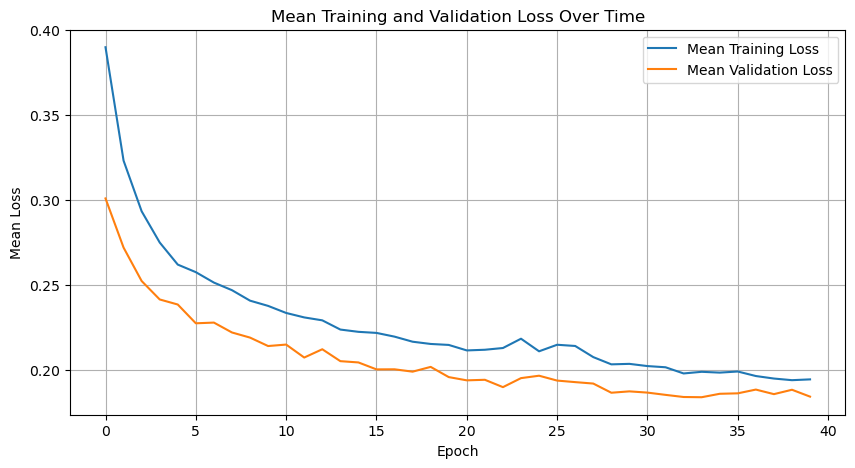

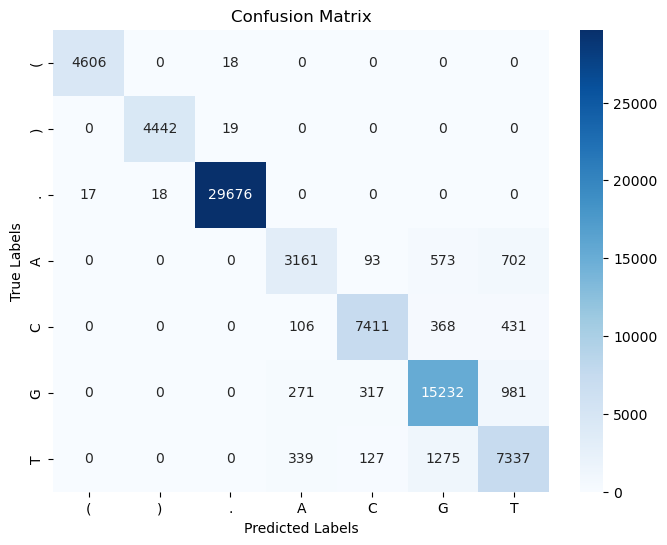

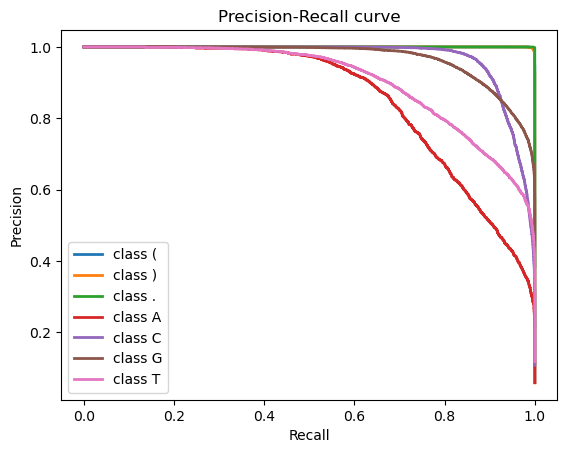

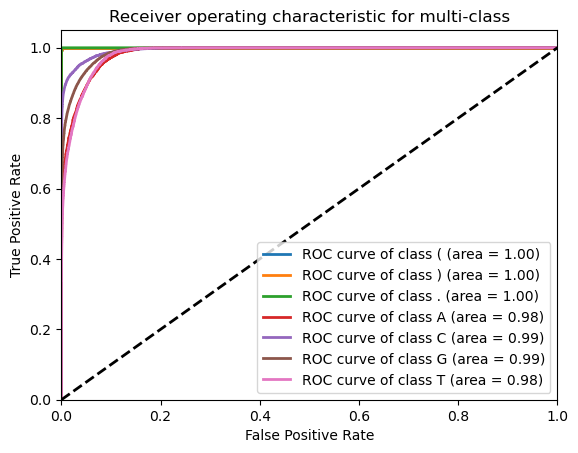


Metrics for nucleotide (:
  Accuracy: 0.9961
  Sensitivity: 0.9961
  Specificity: 0.9998
  MCC: 0.9960

Metrics for nucleotide ):
  Accuracy: 0.9957
  Sensitivity: 0.9957
  Specificity: 0.9998
  MCC: 0.9956

Metrics for nucleotide .:
  Accuracy: 0.9988
  Sensitivity: 0.9988
  Specificity: 0.9992
  MCC: 0.9980

Metrics for nucleotide A:
  Accuracy: 0.6979
  Sensitivity: 0.6979
  Specificity: 0.9902
  MCC: 0.7405

Metrics for nucleotide C:
  Accuracy: 0.8912
  Sensitivity: 0.8912
  Specificity: 0.9922
  MCC: 0.9012

Metrics for nucleotide G:
  Accuracy: 0.9066
  Sensitivity: 0.9066
  Specificity: 0.9635
  MCC: 0.8584

Metrics for nucleotide T:
  Accuracy: 0.8082
  Sensitivity: 0.8082
  Specificity: 0.9691
  MCC: 0.7639


In [8]:
plot_mean_loss(cfg)

plot_confusion_matrix(processed_true, processed_preds)
plot_roc_auc_from_logits(masked_logits, processed_true, tokenizer)
per_token_metrics(processed_true, processed_preds, tokenizer)


### Regression

In [4]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

x_list = load_test_input(filename=f'{cfg["results_path"]}/test_input.pkl')

dna_dataset = load_dataset(cfg)

device = torch.device("cuda:0")  
cfg.update({
    'device': device,
    'rank': 0,
})

model = get_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])

model, optimizer, starting_epoch, metrics = load_checkpoint(model, optimizer, cfg)

# Move the model to evaluation mo
# de if you are doing inference
model = model.eval()
model.n_classes = cfg['num_classes']


Loaded last checkpoint


In [5]:
tokenized_seqs = [inner[0] for inner in x_list]
attn_mask = [~inner[1].bool() for inner in x_list]

test_preds = []

for seqs, mask in zip(tokenized_seqs, attn_mask):
    seqs, mask = seqs.to(device), mask.to(device)
    with torch.no_grad():
        test_preds.append(model.predict_uncertainty(seqs, attn_mask=mask))
    
prob = np.concatenate([pred[0].cpu().numpy() for pred in test_preds])
u = np.concatenate([pred[1].cpu().numpy() for pred in test_preds])
aleatoric = np.concatenate([pred[2].cpu().numpy() for pred in test_preds])
epistemic = np.concatenate([pred[3].cpu().numpy() for pred in test_preds])

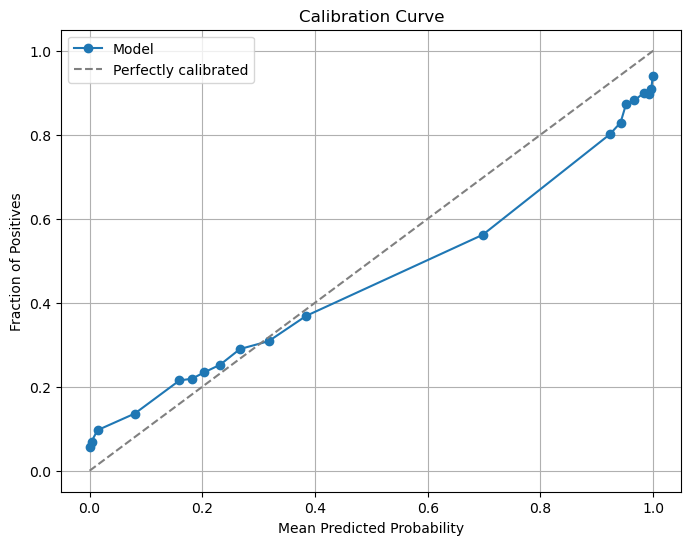

In [13]:
prob_true, prob_pred = calibration_curve(y_true_flat, prob[:, 1], n_bins=20, strategy='quantile')
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
y_true_flat.shape

(19264,)

Accuracy: 0.8158
Precision: 0.8516
Recall: 0.7576
F1-Score: 0.8019
CSI: 0.6692


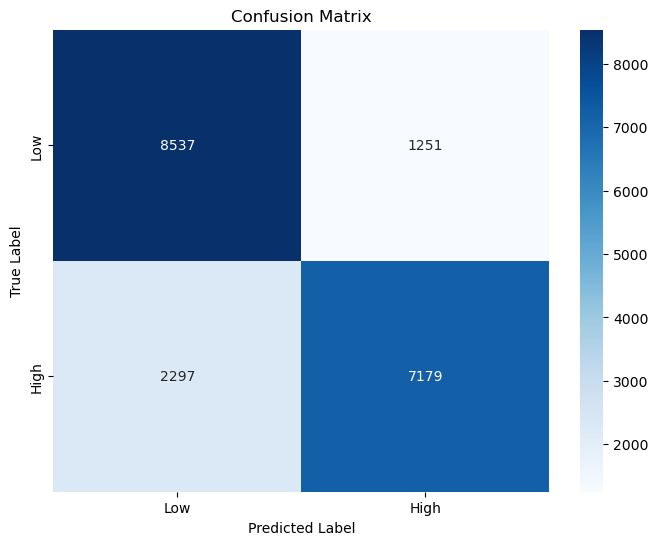

In [7]:
plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])

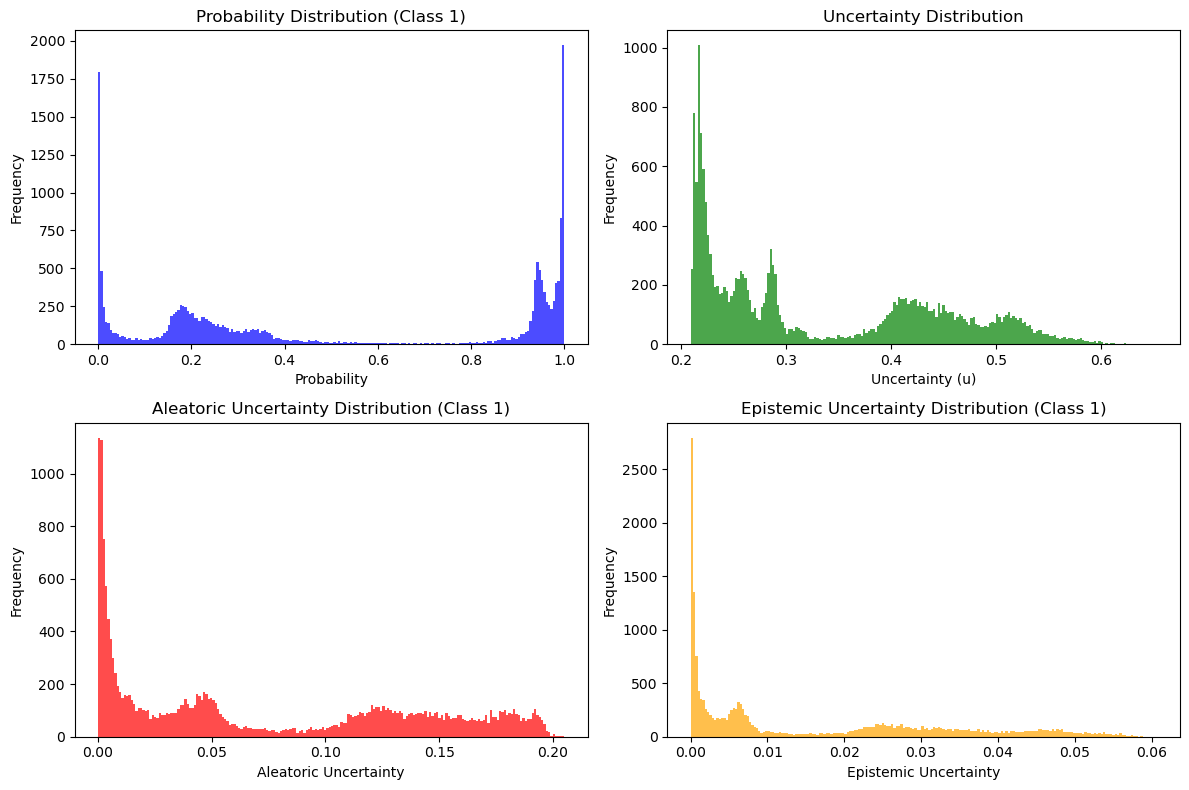

In [11]:
# Assuming the provided data is representative of the full dataset
# Plotting histograms for each metric

plt.figure(figsize=(12, 8))

# Probability histogram for the first class
plt.subplot(2, 2, 1)
plt.hist(prob[:, 1], bins=200, alpha=0.7, color='blue')
plt.title('Probability Distribution (Class 1)')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Uncertainty (u) histogram
plt.subplot(2, 2, 2)
plt.hist(u[:, 0], bins=200, alpha=0.7, color='green')
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty (u)')
plt.ylabel('Frequency')

# Aleatoric uncertainty histogram for the first class
plt.subplot(2, 2, 3)
plt.hist(aleatoric[:, 1], bins=200, alpha=0.7, color='red')
plt.title('Aleatoric Uncertainty Distribution (Class 1)')
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Frequency')

# Epistemic uncertainty histogram for the first class
plt.subplot(2, 2, 4)
plt.hist(epistemic[:, 1], bins=200, alpha=0.7, color='orange')
plt.title('Epistemic Uncertainty Distribution (Class 1)')
plt.xlabel('Epistemic Uncertainty')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

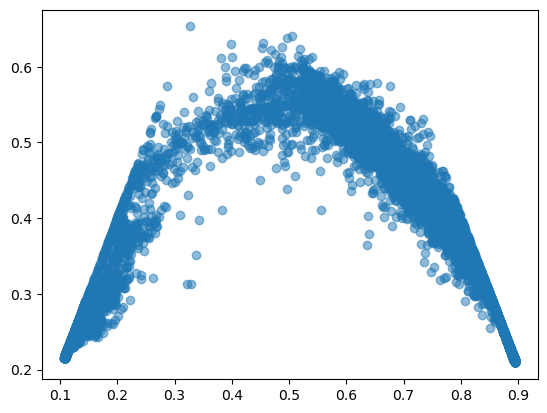

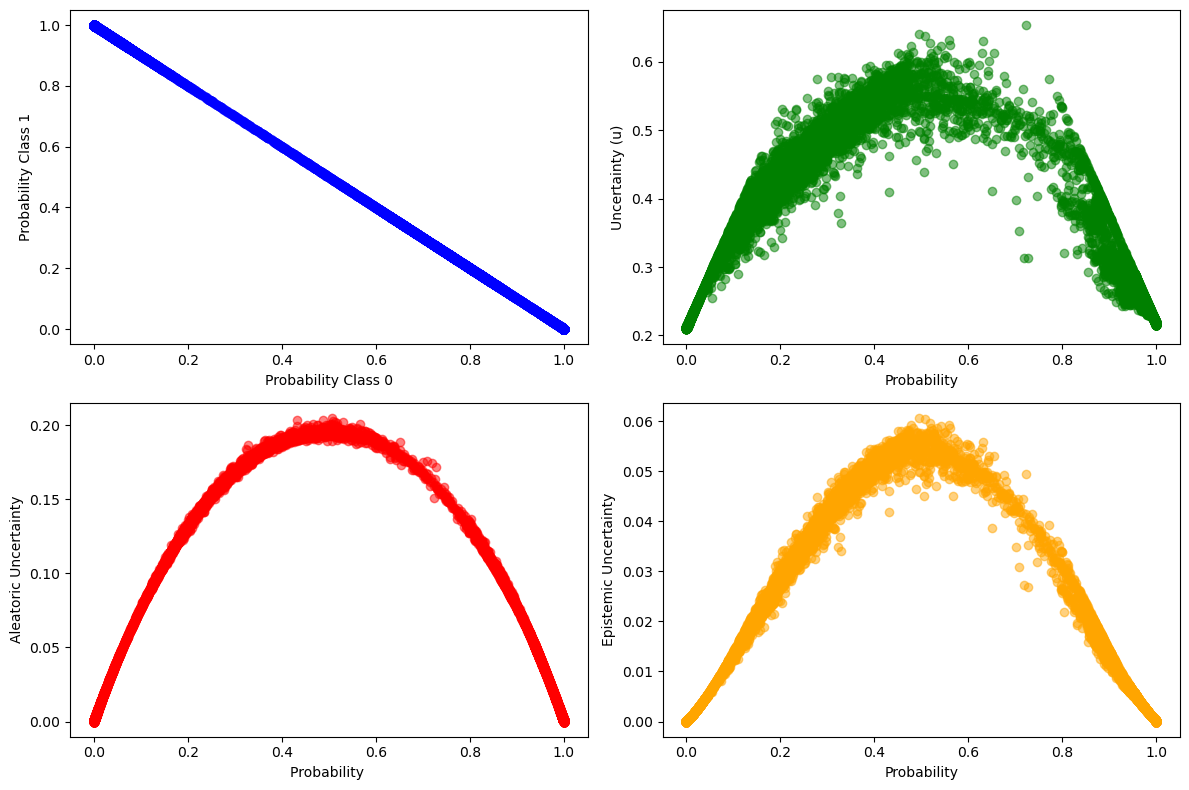

: 

In [18]:
# Assuming the provided data is representative of the full dataset
# Plotting histograms for each metric

plt.figure(figsize=(12, 8))

# Probability histogram for the first class
plt.subplot(2, 2, 1)
plt.plot(prob[:, 0], prob[:, 1], 'o', alpha=0.5, color='blue')
plt.xlabel('Probability Class 0')
plt.ylabel('Probability Class 1')

# Uncertainty (u) histogram
plt.subplot(2, 2, 2)
plt.plot(prob[:, 1], u[:, 0], 'o', alpha=0.5, color='green')
# plt.title('Uncertainty Distribution')
plt.ylabel('Uncertainty (u)')
plt.xlabel('Probability')

# Aleatoric uncertainty histogram for the first class
plt.subplot(2, 2, 3)
plt.plot(prob[:, 1], aleatoric[:, 1], 'o', alpha=0.5, color='red')
# plt.title('Aleatoric Uncertainty Distribution (Class 0)')
plt.ylabel('Aleatoric Uncertainty')
plt.xlabel('Probability ')

# Epistemic uncertainty histogram for the first class
plt.subplot(2, 2, 4)
plt.plot(prob[:, 1], epistemic[:, 1], 'o', alpha=0.5, color='orange')
# plt.title('Epistemic Uncertainty Distribution (Class 0)')
plt.ylabel('Epistemic Uncertainty')
plt.xlabel('Probability')

plt.tight_layout()
plt.show()

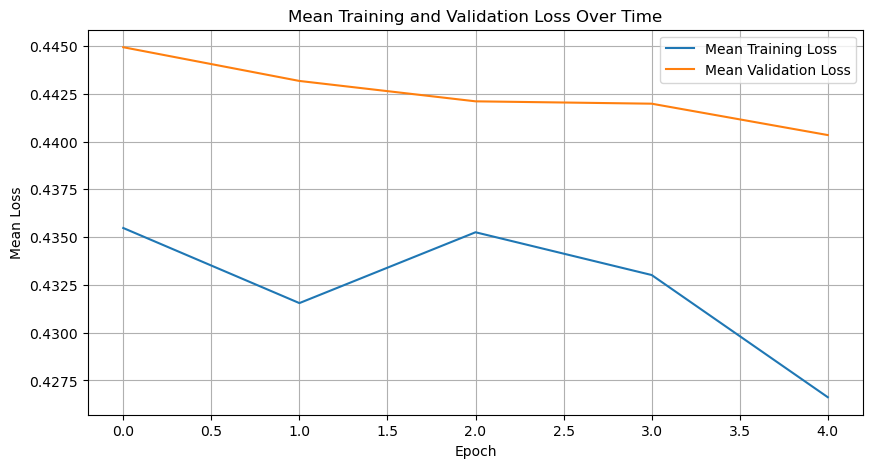

Accuracy: 0.8252
Precision: 0.8597
Recall: 0.7728
F1-Score: 0.8140
CSI: 0.6863


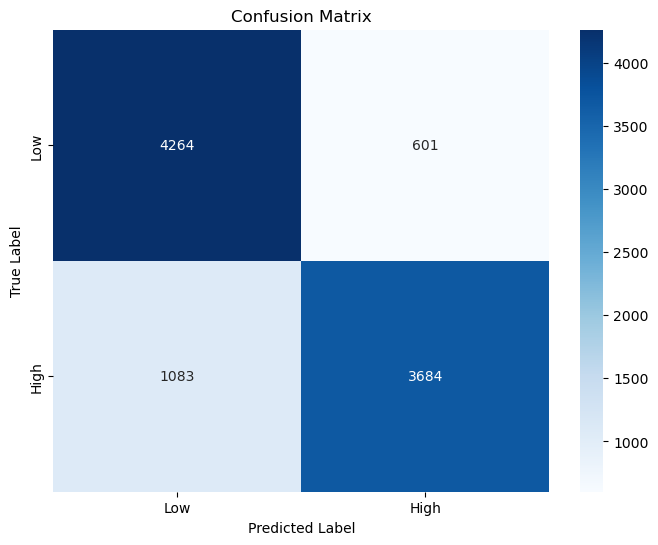

In [5]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

plot_mean_loss(cfg)

y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')

y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])



# Seq Struct MLM

In [95]:
cfg = read_cfg('../aptamer_transformer/config.yaml')


tokenizer = AutoTokenizer.from_pretrained(cfg['seq_struct_tokenizer_path'])

y_true_list, y_pred_list = load_test_predictions(
    filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)

y_pred_flat_src = []
y_pred_flat_tgt = []

for y_pred in y_pred_list:
    
    y_pred_flat_src.extend(y_pred[0].cpu().numpy())
    y_pred_flat_tgt.extend(y_pred[2].cpu().numpy())
    

y_preds = np.array(y_pred_flat_src)
target = np.array(y_pred_flat_tgt)
y_true = np.array(y_true_flat)

# y_true_tokenized = np.array(tokenizer(list(map(lambda x: ' '.join(x), y_true)), padding=True).input_ids)
y_preds_tokenized = np.array(np.argmax(y_preds, axis=2))

processed_preds, processed_true = process_data(y_preds, target)
masked_logits = extract_masked_logits(y_preds, target)
masked_logits = masked_logits[:, 5:]

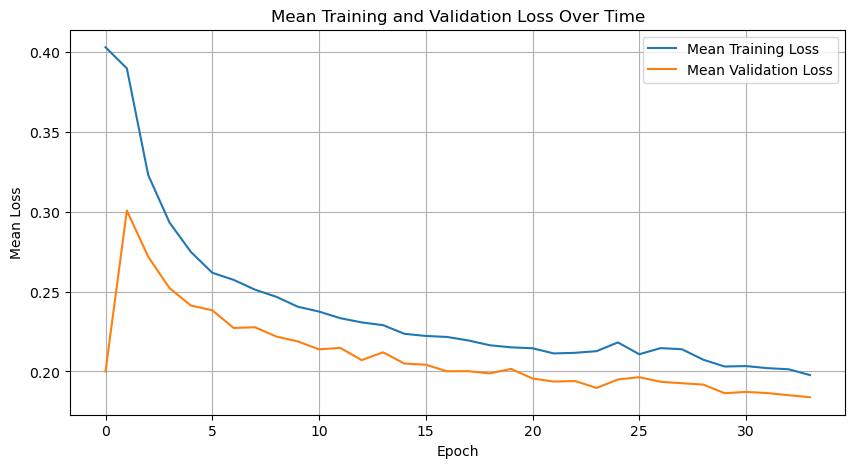

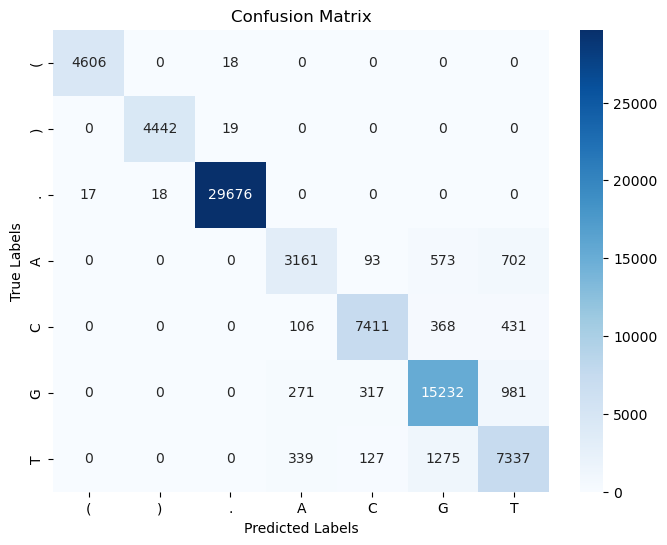

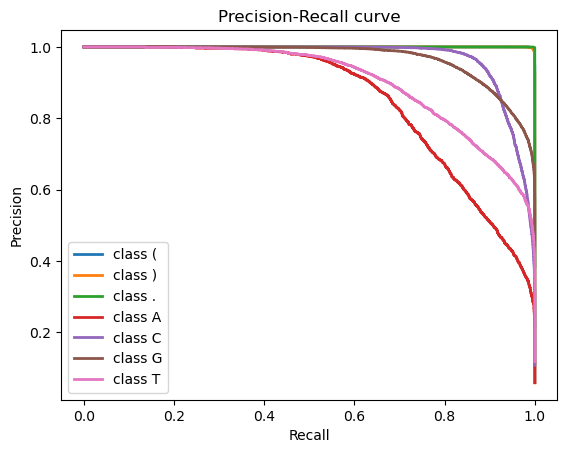

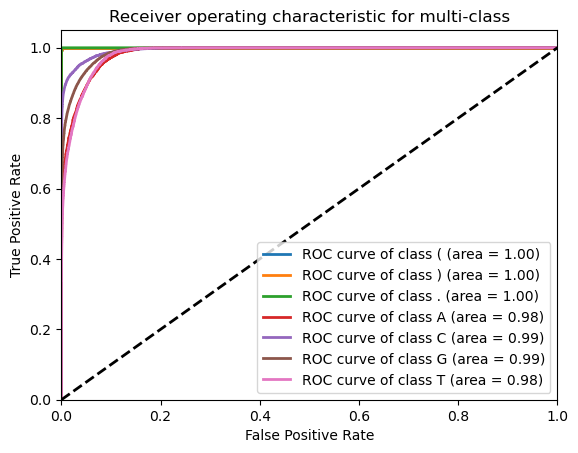


Metrics for nucleotide (:
  Accuracy: 0.9961
  Sensitivity: 0.9961
  Specificity: 0.9998
  MCC: 0.9960

Metrics for nucleotide ):
  Accuracy: 0.9957
  Sensitivity: 0.9957
  Specificity: 0.9998
  MCC: 0.9956

Metrics for nucleotide .:
  Accuracy: 0.9988
  Sensitivity: 0.9988
  Specificity: 0.9992
  MCC: 0.9980

Metrics for nucleotide A:
  Accuracy: 0.6979
  Sensitivity: 0.6979
  Specificity: 0.9902
  MCC: 0.7405

Metrics for nucleotide C:
  Accuracy: 0.8912
  Sensitivity: 0.8912
  Specificity: 0.9922
  MCC: 0.9012

Metrics for nucleotide G:
  Accuracy: 0.9066
  Sensitivity: 0.9066
  Specificity: 0.9635
  MCC: 0.8584

Metrics for nucleotide T:
  Accuracy: 0.8082
  Sensitivity: 0.8082
  Specificity: 0.9691
  MCC: 0.7639


In [104]:
plot_mean_loss(cfg)

plot_confusion_matrix(processed_true, processed_preds)
plot_roc_auc_from_logits(masked_logits, processed_true, tokenizer)
per_token_metrics(processed_true, processed_preds, tokenizer)


### Seq Struct Regression

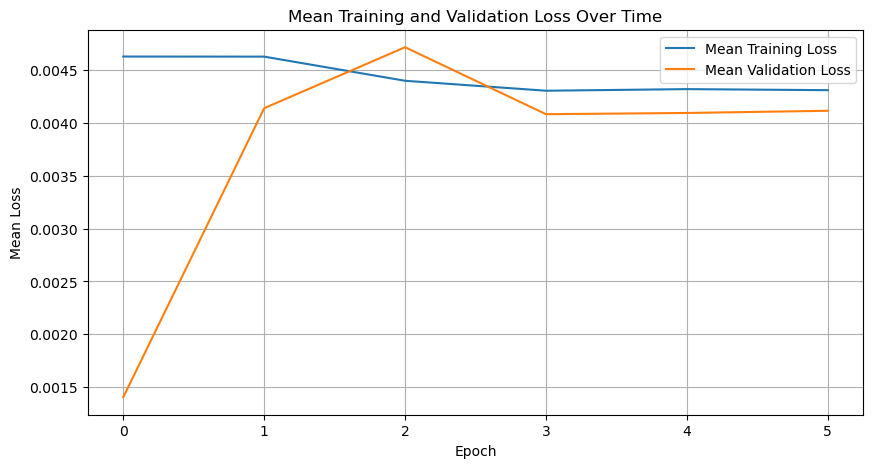

In [56]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)

## Seq Struct X Transformer regression

In [7]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Explained Variance Score: {explained_variance}")

RuntimeError: Attempting to deserialize object on CUDA device 5 but torch.cuda.device_count() is 4. Please use torch.load with map_location to map your storages to an existing device.

In [ ]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)

# Masked Language Model Analysis

In [49]:
cfg = read_cfg('config.yaml')


tokenizer = AutoTokenizer.from_pretrained('../data/AptamerBERT_tokenizer')

y_true_list, y_pred_list = load_test_predictions(
    filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)

y_pred_flat_src = []
y_pred_flat_tgt = []

for y_pred in y_pred_list:
    
    y_pred_flat_src.extend(y_pred[0].cpu())
    y_pred_flat_tgt.extend(y_pred[2].cpu())

y_preds = np.array(y_pred_flat_src)
target = np.array(y_pred_flat_tgt)
y_true = np.array(y_true_flat)

# y_true_tokenized = np.array(tokenizer(list(map(lambda x: ' '.join(x), y_true)), padding=True).input_ids)
y_preds_tokenized = np.array(np.argmax(y_preds,axis=2))

processed_preds, processed_true = process_data(y_preds, target)
masked_logits = extract_masked_logits(y_preds, target)

### MLM X Aptamer BERT Flash Attention & Rot_pos_encoding & GELU

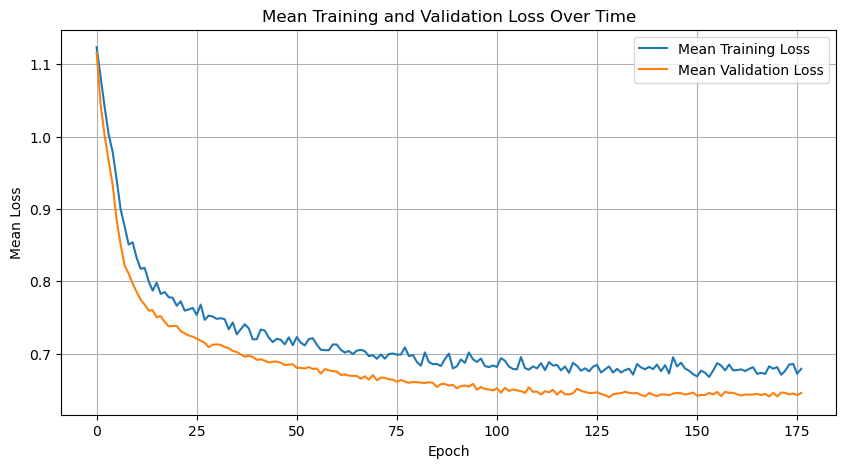

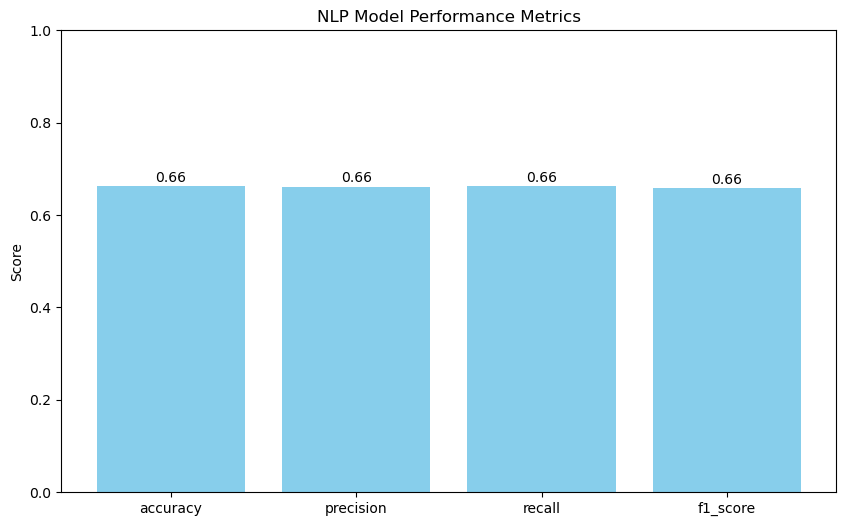

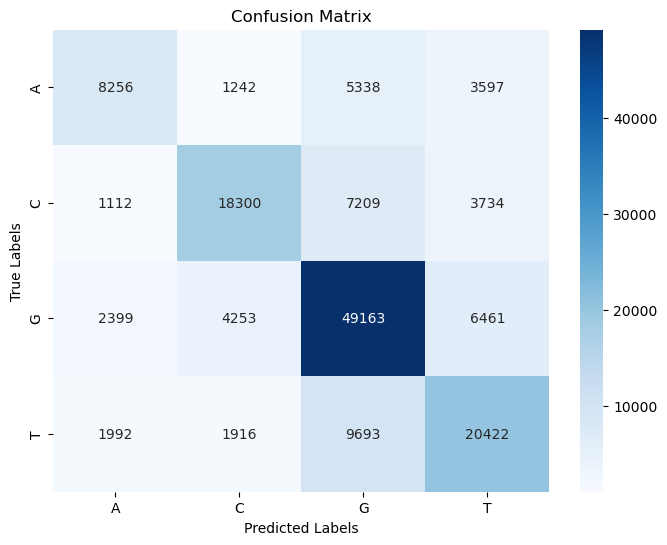

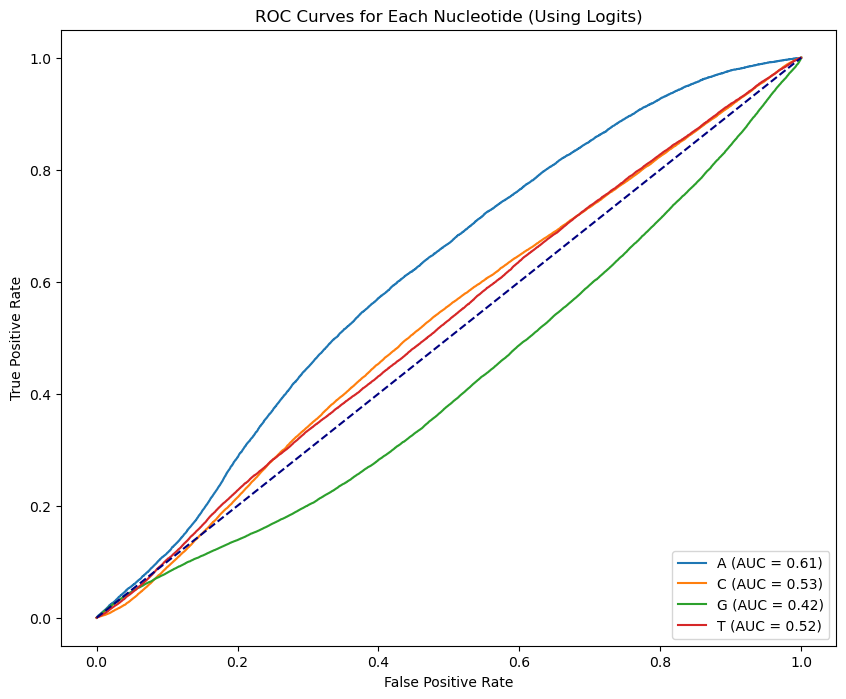


Metrics for nucleotide A:
  Accuracy: 0.4479
  Sensitivity: 0.4479
  Specificity: 0.9566
  MCC: 0.4597

Metrics for nucleotide C:
  Accuracy: 0.6029
  Sensitivity: 0.6029
  Specificity: 0.9354
  MCC: 0.5734

Metrics for nucleotide G:
  Accuracy: 0.7894
  Sensitivity: 0.7894
  Specificity: 0.7314
  MCC: 0.5157

Metrics for nucleotide T:
  Accuracy: 0.6002
  Sensitivity: 0.6002
  Specificity: 0.8758
  MCC: 0.4751


In [50]:
plot_mean_loss(cfg)

plot_metrics(processed_true, processed_preds)
plot_confusion_matrix(processed_true, processed_preds)
plot_roc_auc_from_logits(masked_logits, processed_true)
per_token_metrics(processed_true, processed_preds)


In [65]:
common_error_subsequences_with_pos = find_common_error_subsequences_around_masked(y_true_tokenized, y_preds_tokenized, target, window_size=9)

plot_error_position_distribution(common_error_subsequences_with_pos)

NameError: name 'y_true_tokenized' is not defined

In [ ]:
common_error_subsequences_with_pos

# Classification Analysis

#### Data Analysis

In [42]:
cfg = read_cfg('config.yaml')
dna_dataset = load_dataset(cfg)

Total data: 1287750
Max sequence length: 41


<Axes: >

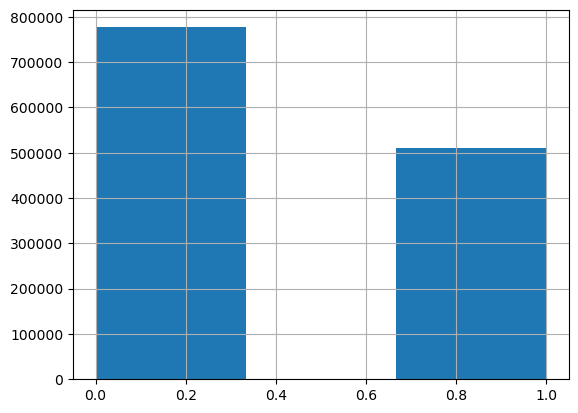

In [61]:
total_data, max_seq_len = dna_dataset.attn_masks.shape
max_seq_len = max_seq_len - 1
seq_len_dist = torch.sum(dna_dataset.attn_masks, axis=1) - 1
enrichment_scores_dist = dna_dataset.y

print(f'Total data: {total_data}')
print(f'Max sequence length: {max_seq_len}')
H, bins = np.histogram([int(cla) for cla in  enrichment_scores_dist.tolist()], bins=2)
enrichment_scores_dist.hist(bins=3)
# plt.bar([0,1],  labels)


#### Transformer Encoder Classification

Accuracy: 0.6668
Precision: 0.5721
Recall: 0.6590
F1-Score: 0.6125
CSI: 0.4414


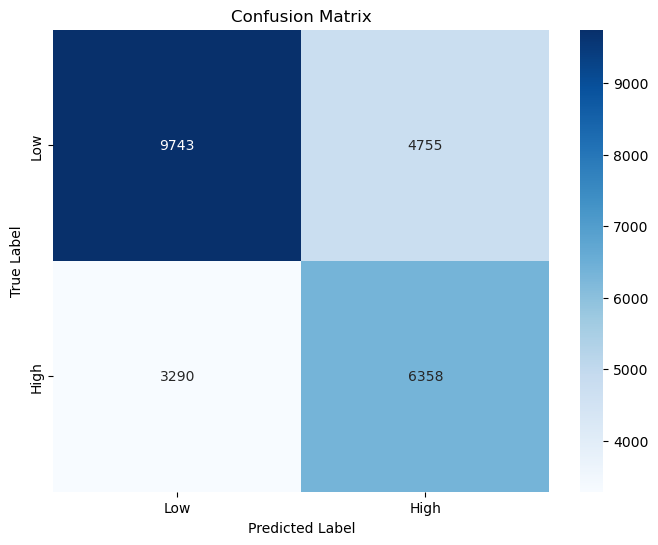

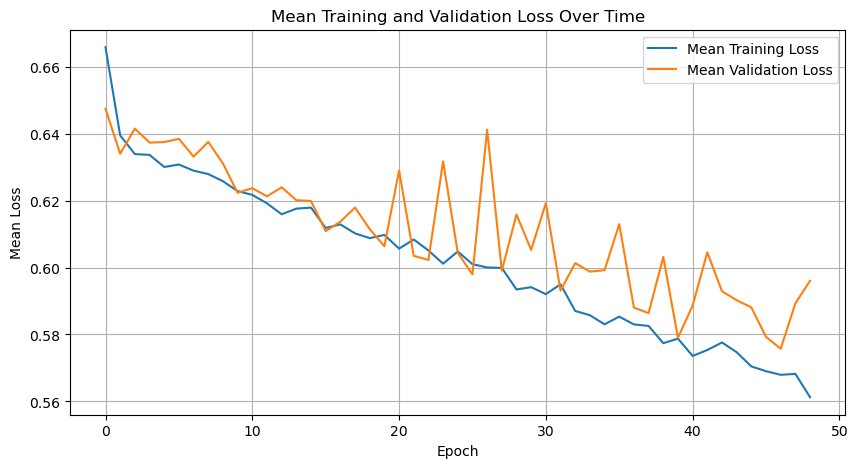

In [74]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])

plot_mean_loss(cfg)


#### Aptamer BERT Classification

Accuracy: 0.7163
Precision: 0.6289
Recall: 0.6919
F1-Score: 0.6589
CSI: 0.4913


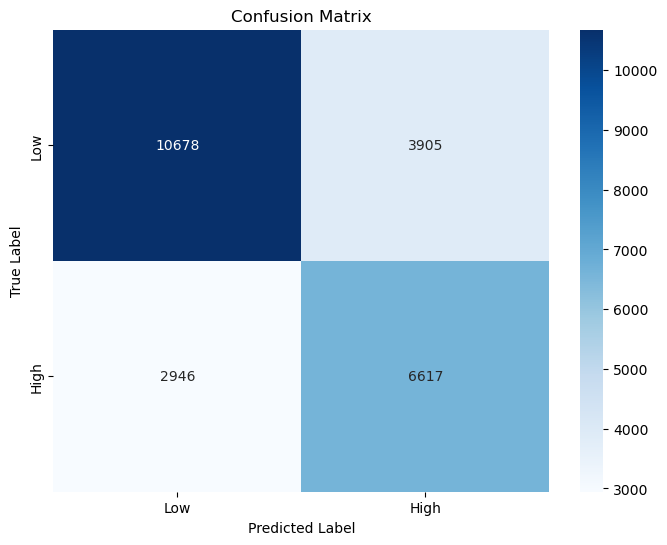

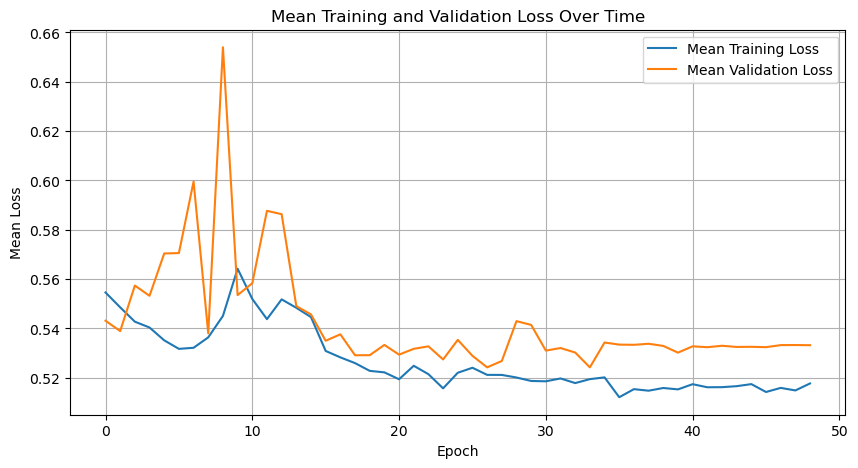

In [75]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])

plot_mean_loss(cfg)


Accuracy: 0.8221
Precision: 0.8567
Recall: 0.7712
F1-Score: 0.8117
CSI: 0.6831


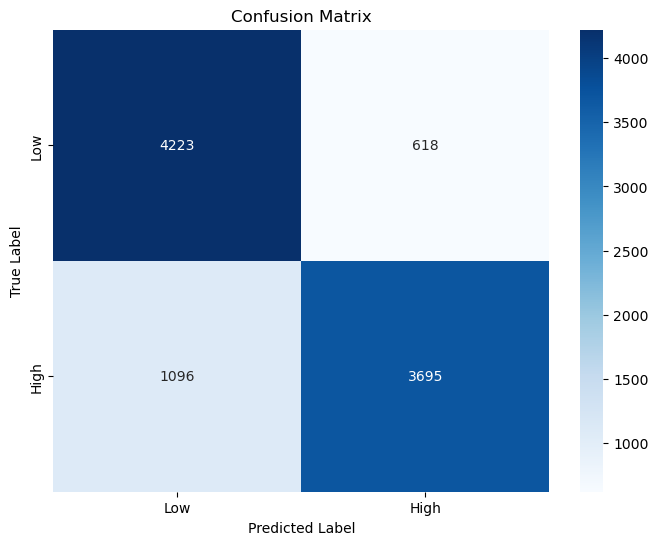

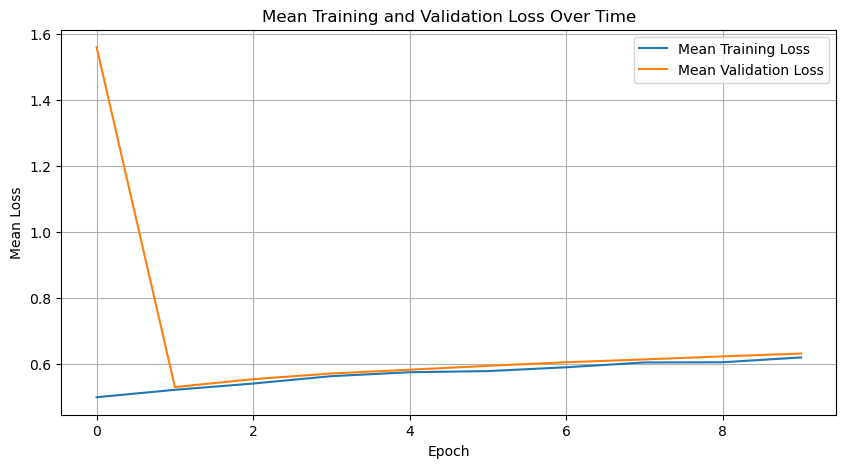

In [106]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])

plot_mean_loss(cfg)


#### X Aptamer Bert Classifier

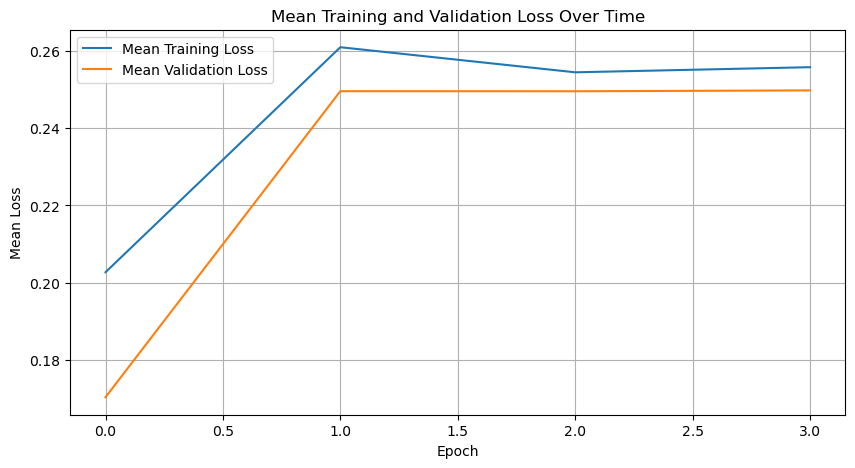

Accuracy: 0.8885
Precision: 0.4944
Recall: 0.2491
F1-Score: 0.3313
CSI: 0.1985


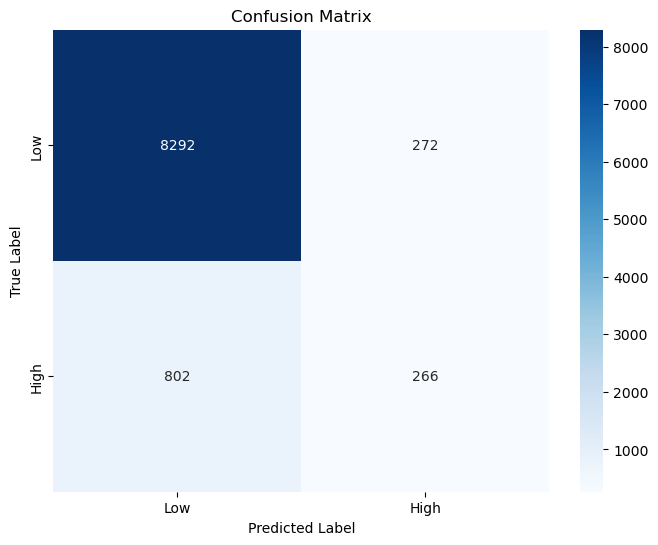

In [63]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

plot_mean_loss(cfg)

y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')

y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])



# Evidence Analysis

## Test Data

In [124]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

x_list = load_test_input(filename=f'{cfg["results_path"]}/test_input.pkl')

dna_dataset = load_dataset(cfg)

device = torch.device("cpu")  
cfg.update({
    'device': device,
})

model = get_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])

# Load the checkpoint
checkpoint = torch.load(cfg['checkpoint_path'])  # Replace X with the epoch number

# Restore the model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model to evaluation mo
# de if you are doing inference
model = model.eval()
model.n_classes = cfg['num_classes']


In [123]:
del model

In [115]:
tokenized_seqs = [inner[0] for inner in x_list]
attn_mask = [~inner[1].bool() for inner in x_list]


In [116]:
tokenized_seqs = [inner[0] for inner in x_list]
attn_mask = [~inner[1].bool() for inner in x_list]

test_preds = []

for seqs, mask in zip(tokenized_seqs, attn_mask):
    seqs, mask = seqs.to(device), mask.to(device)
    with torch.no_grad():
        test_preds.append(model.predict_uncertainty(seqs, attn_mask=mask))
    
prob = np.concatenate([pred[0].cpu().numpy() for pred in test_preds])
u = np.concatenate([pred[1].cpu().numpy() for pred in test_preds])
aleatoric = np.concatenate([pred[2].cpu().numpy() for pred in test_preds])
epistemic = np.concatenate([pred[3].cpu().numpy() for pred in test_preds])

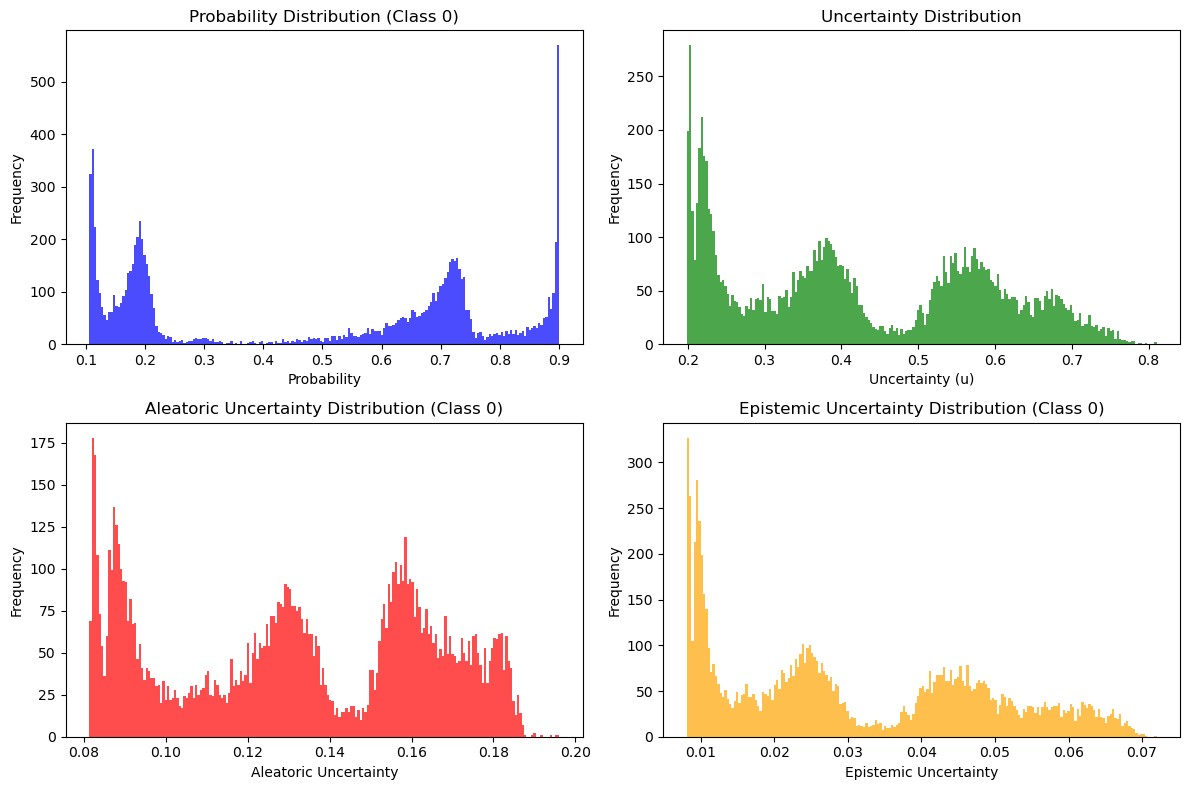

In [117]:
# Assuming the provided data is representative of the full dataset
# Plotting histograms for each metric

plt.figure(figsize=(12, 8))

# Probability histogram for the first class
plt.subplot(2, 2, 1)
plt.hist(prob[:, 0], bins=200, alpha=0.7, color='blue')
plt.title('Probability Distribution (Class 0)')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Uncertainty (u) histogram
plt.subplot(2, 2, 2)
plt.hist(u[:, 0], bins=200, alpha=0.7, color='green')
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty (u)')
plt.ylabel('Frequency')

# Aleatoric uncertainty histogram for the first class
plt.subplot(2, 2, 3)
plt.hist(aleatoric[:, 0], bins=200, alpha=0.7, color='red')
plt.title('Aleatoric Uncertainty Distribution (Class 0)')
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Frequency')

# Epistemic uncertainty histogram for the first class
plt.subplot(2, 2, 4)
plt.hist(epistemic[:, 0], bins=200, alpha=0.7, color='orange')
plt.title('Epistemic Uncertainty Distribution (Class 0)')
plt.xlabel('Epistemic Uncertainty')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [119]:
prob

array([[0.18585318, 0.8141468 ],
       [0.11245163, 0.8875484 ],
       [0.88939536, 0.11060461],
       ...,
       [0.6864236 , 0.31357634],
       [0.88873094, 0.11126904],
       [0.7902939 , 0.2097061 ]], dtype=float32)

In [1]:
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_flat, prob, n_bins=20)


# Plotting
plt.figure(figsize=(10, 8))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

NameError: name 'y_true_flat' is not defined

Accuracy: 0.8221
Precision: 0.8567
Recall: 0.7712
F1-Score: 0.8117
CSI: 0.6831


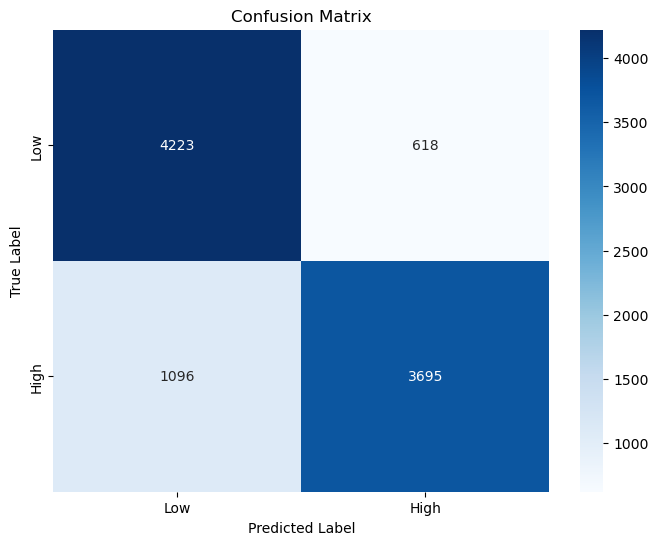

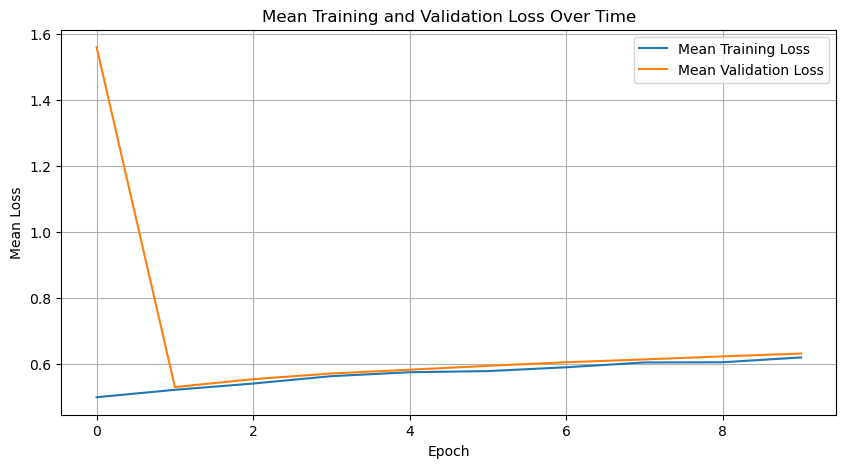

In [122]:
plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])
plot_mean_loss(cfg)

## All Data

In [8]:
dna_dataset = load_dataset(cfg)

In [9]:
all_loader = DataLoader(dna_dataset, batch_size=2048)

In [10]:

all_preds = []

for seqs, mask, y in all_loader:
    seqs = seqs.long().to(device)
    mask = ~mask.bool().to(device)
    with torch.no_grad():
        all_preds.append(model.predict_uncertainty(seqs, attn_mask=mask))
    
prob = np.concatenate([pred[0].cpu().numpy() for pred in all_preds])
u = np.concatenate([pred[1].cpu().numpy() for pred in all_preds])
aleatoric = np.concatenate([pred[2].cpu().numpy() for pred in all_preds])
epistemic = np.concatenate([pred[3].cpu().numpy() for pred in all_preds])

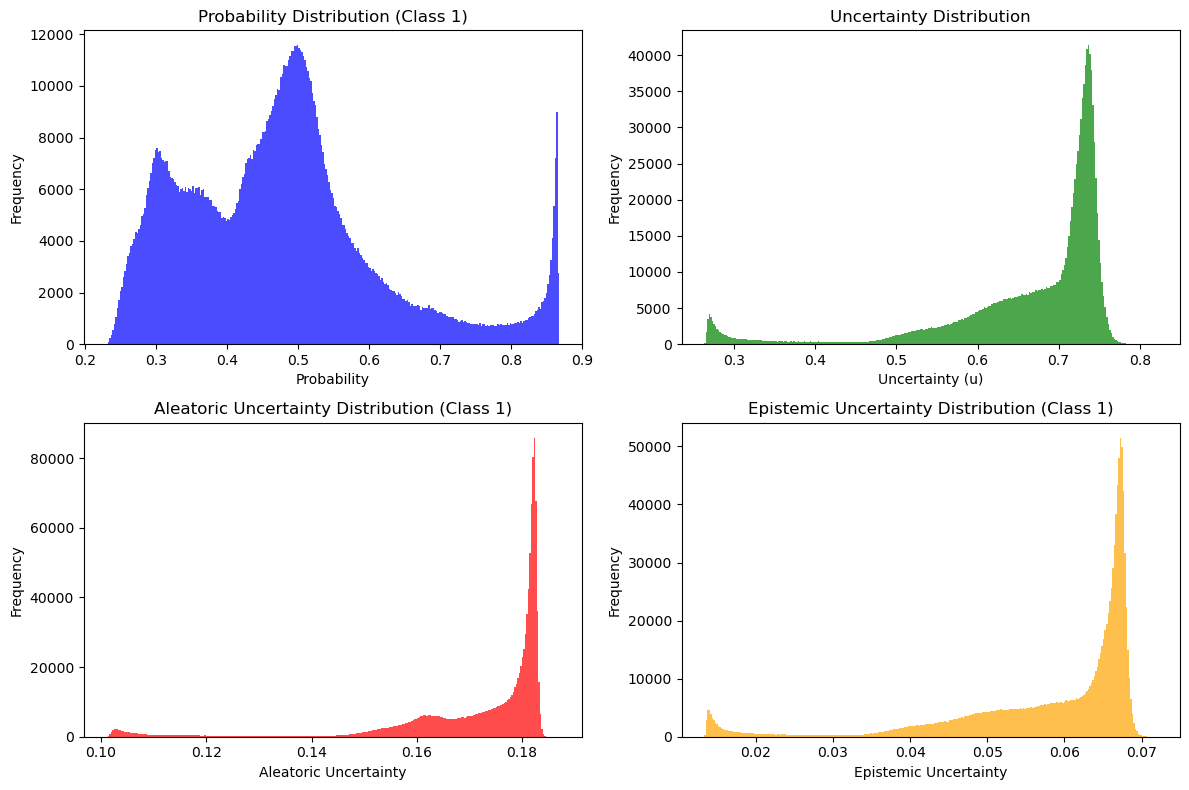

In [11]:
# Assuming the provided data is representative of the full dataset
# Plotting histograms for each metric

plt.figure(figsize=(12, 8))

# Probability histogram for the first class
plt.subplot(2, 2, 1)
plt.hist(prob[:, 0], bins=300, alpha=0.7, color='blue')
plt.title('Probability Distribution (Class 1)')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Uncertainty (u) histogram
plt.subplot(2, 2, 2)
plt.hist(u[:, 0], bins=300, alpha=0.7, color='green')
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty (u)')
plt.ylabel('Frequency')

# Aleatoric uncertainty histogram for the first class
plt.subplot(2, 2, 3)
plt.hist(aleatoric[:, 0], bins=300, alpha=0.7, color='red')
plt.title('Aleatoric Uncertainty Distribution (Class 1)')
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Frequency')

# Epistemic uncertainty histogram for the first class
plt.subplot(2, 2, 4)
plt.hist(epistemic[:, 0], bins=300, alpha=0.7, color='orange')
plt.title('Epistemic Uncertainty Distribution (Class 1)')
plt.xlabel('Epistemic Uncertainty')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Regression Analysis

### Data Analysis

In [6]:
cfg = read_cfg('config.yaml')
dna_dataset = load_dataset(cfg)

Total data: 1287750
Max sequence length: 41


Text(0, 0.5, 'Frequency')

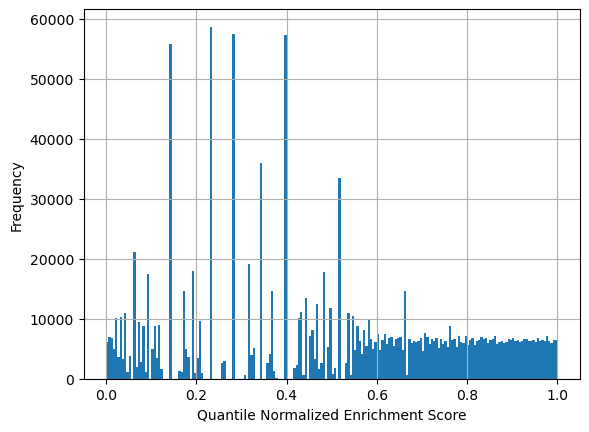

In [28]:
total_data, max_seq_len = dna_dataset.attn_masks.shape
max_seq_len = max_seq_len - 1
seq_len_dist = torch.sum(dna_dataset.attn_masks, axis=1) - 1
enrichment_scores_dist = dna_dataset.y

print(f'Total data: {total_data}')
print(f'Max sequence length: {max_seq_len}')

ax = enrichment_scores_dist.hist(bins=200)
ax.set_xlabel('Quantile Normalized Enrichment Score')
ax.set_ylabel('Frequency')


#### Transformer Encoder Regression

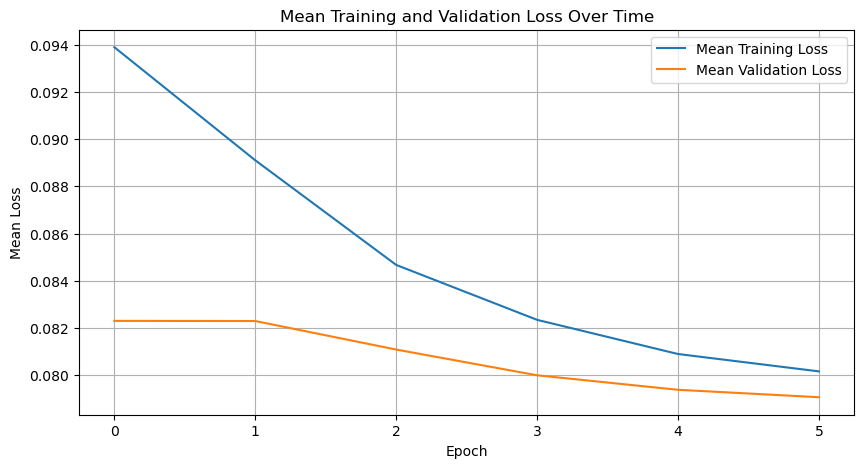

Mean Squared Error (MSE): 0.07900990854452324
Root Mean Squared Error (RMSE): 0.2810870124081211
Mean Absolute Error (MAE): 0.24110928155043065
R-squared (Coefficient of Determination): 0.05139351643622547
Mean Absolute Percentage Error (MAPE): 83377458581.66556
Explained Variance Score: 0.05197999383037699


In [4]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Explained Variance Score: {explained_variance}")

#### Aptamer Bert Regression

Mean Squared Error (MSE): 0.05982096267716389
Root Mean Squared Error (RMSE): 0.24458324283802416
Mean Absolute Error (MAE): 0.18763397610142502
R-squared (Coefficient of Determination): 0.28052996225501425
Mean Absolute Percentage Error (MAPE): 146963398314.716
Explained Variance Score: 0.3228510037489257


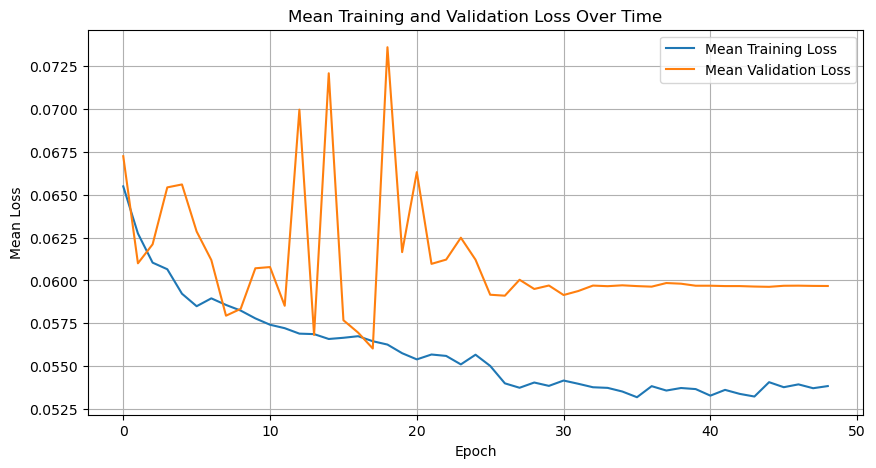

In [37]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)


#### X Transformer Encoder: Flash Attention Only

Mean Squared Error (MSE): 0.07066502439468147
Root Mean Squared Error (RMSE): 0.26582893821907627
Mean Absolute Error (MAE): 0.22437445442451331
R-squared (Coefficient of Determination): 0.1548477408205594
Mean Absolute Percentage Error (MAPE): 53546236518.49766
Explained Variance Score: 0.15490687889868393


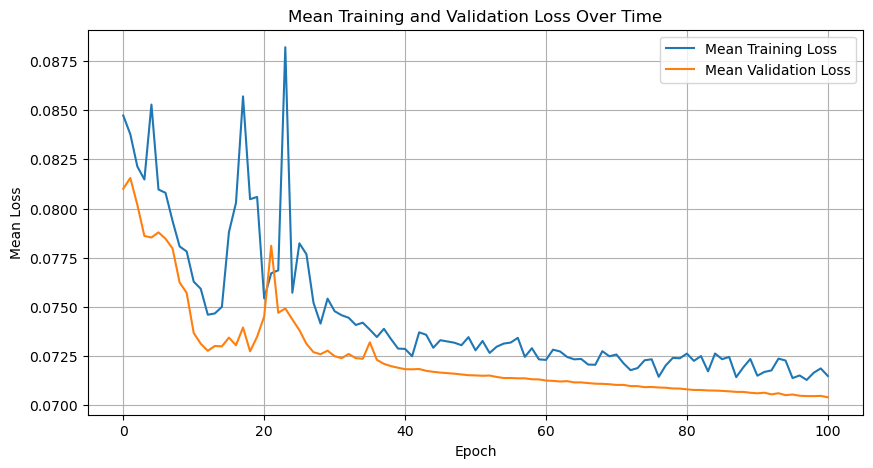

In [32]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)


#### X Transformer Encoder: Flash Attention & Rot_pos_encoding & GELU

Mean Squared Error (MSE): 0.05780383738869848
Root Mean Squared Error (RMSE): 0.24042428618735354
Mean Absolute Error (MAE): 0.19064411145939486
R-squared (Coefficient of Determination): 0.30628093689833225
Mean Absolute Percentage Error (MAPE): 2.8901119697552677
Explained Variance Score: 0.3097624760745812


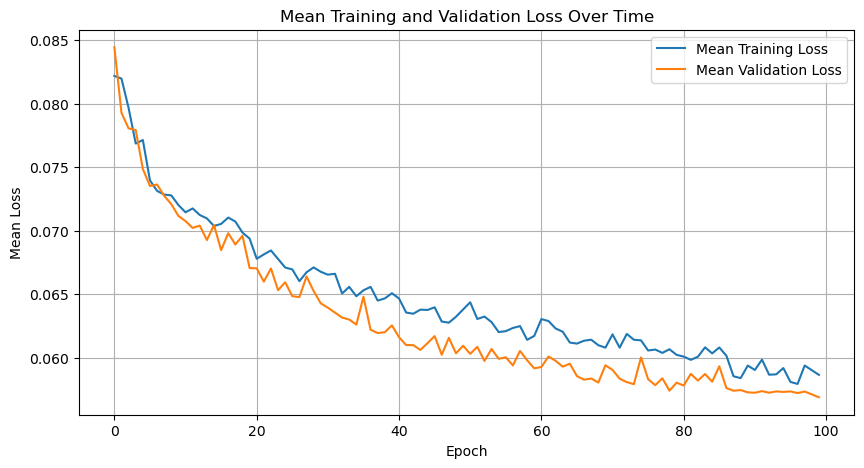

In [37]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)


#### X Aptamer Bert Regression

Mean Squared Error (MSE): 0.05788969944814557
Root Mean Squared Error (RMSE): 0.24060278354197312
Mean Absolute Error (MAE): 0.1883356513701626
R-squared (Coefficient of Determination): 0.3033276662340444
Mean Absolute Percentage Error (MAPE): 32.19012657549618
Explained Variance Score: 0.3151967494708119


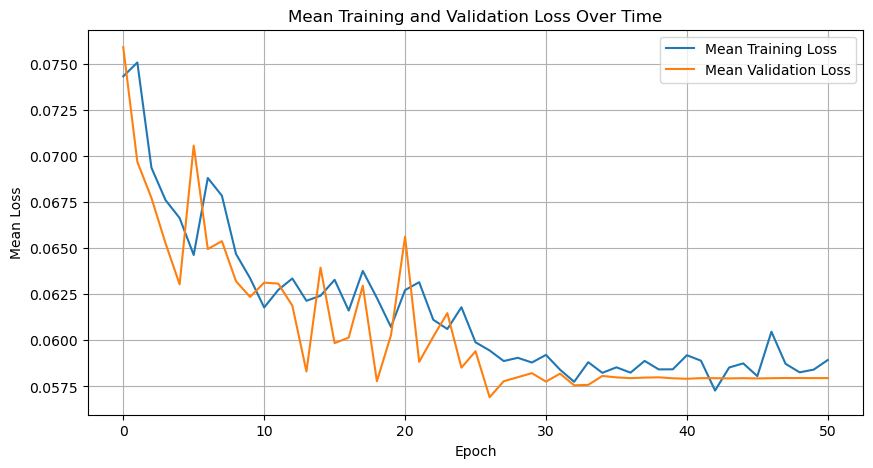

In [53]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)
